In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
os.path.dirname(sys.executable)
sys.path.append('/kuacc/users/ckoksal20/COMP547Project/SSuperGAN/')
from data.datasets.random_dataset import RandomDataset
from data.datasets.golden_panels import GoldenPanelsDataset
from data.augment import get_PIL_image

from networks.ssupervae import SSuperVAE
from networks.ssuper_dcgan import SSuperDCGAN

from training.vae_trainer import VAETrainer
from utils.config_utils import read_config, Config
from utils.logging_utils import *
from utils.plot_utils import *
from utils import pytorch_util as ptu

from configs.base_config import *
from functional.losses.elbo import elbo







Random Seed:  999


In [3]:
ptu.set_gpu_mode(True)
config = read_config(Config.SSUPERDCGAN)
golden_age_config = read_config(Config.GOLDEN_AGE)
model_path = "ckpts/ssuper_dcgan-checkpoint-epoch97.pth"

net_ssuper_dcgan = SSuperDCGAN(config.backbone, 
                    latent_dim=config.latent_dim, 
                    embed_dim=config.embed_dim,
                    use_lstm=config.use_lstm,
                    seq_size=config.seq_size,
                    gen_img_size=config.image_dim,
                    lstm_hidden=config.lstm_hidden,
                    lstm_dropout=config.lstm_dropout,
                    fc_hidden_dims=config.fc_hidden_dims,
                    fc_dropout=config.fc_dropout,
                    num_lstm_layers=config.num_lstm_layers,
                    masked_first=config.masked_first,
                    ngpu = config.ngpu,
                    ngf = config.ngf,
                    ndf = config.ndf,
                    nc = config.nc,
                    image_size=config.image_dim).to(ptu.device) 


net_ssuper_dcgan.load_state_dict(torch.load(model_path)['model_state_dict'])
net_ssuper_dcgan = net_ssuper_dcgan.cuda().eval()

dataset = GoldenPanelsDataset(golden_age_config.panel_path,
                              golden_age_config.sequence_path, 
                              golden_age_config.panel_dim,
                              config.image_dim, 
                              augment=False, 
                              mask_val=1, # mask with white color for 1 and black color for 0
                              mask_all=False, # masks faces from all panels and returns all faces
                              return_mask=True,
                              train_test_ratio=golden_age_config.train_test_ratio,
                              train_mode=False,
                              limit_size=-1)

data_loader = DataLoader(dataset, batch_size=1)


#N_SAMPLES = 1280 # 50000


Loaded pretrained weights for efficientnet-b5
DCGAN PRAMS ngpu : 1  image_size : 64  nc : 3 latent_dim : 256  ngf : 64 ndf 64


In [4]:
config = read_config(Config.SSUPERVAE)
golden_age_config = read_config(Config.GOLDEN_AGE)
dc_config = read_config(Config.SSUPERDCGAN)
ptu.set_gpu_mode(True)


net_ssupervae = SSuperVAE(config.backbone, 
                latent_dim=config.latent_dim, 
                embed_dim=config.embed_dim,
                use_lstm=False,
                seq_size=config.seq_size,
                decoder_channels=config.decoder_channels,
                gen_img_size=config.image_dim,
                lstm_hidden=config.lstm_hidden,
                lstm_dropout=config.lstm_dropout,
                fc_hidden_dims=config.fc_hidden_dims,
                fc_dropout=config.fc_dropout,
                num_lstm_layers=config.num_lstm_layers,
                masked_first=config.masked_first).to(ptu.device) 

load_path = "/userfiles/comics_grp/pretrained_models/plain_ssupervae_epoch85.pth"
net_ssupervae.load_state_dict(torch.load(load_path)['model_state_dict'])
net_ssupervae = net_ssupervae.cuda().eval()

Loaded pretrained weights for efficientnet-b5


In [5]:
dl_iter = iter(data_loader)

[INFO] Example: 0


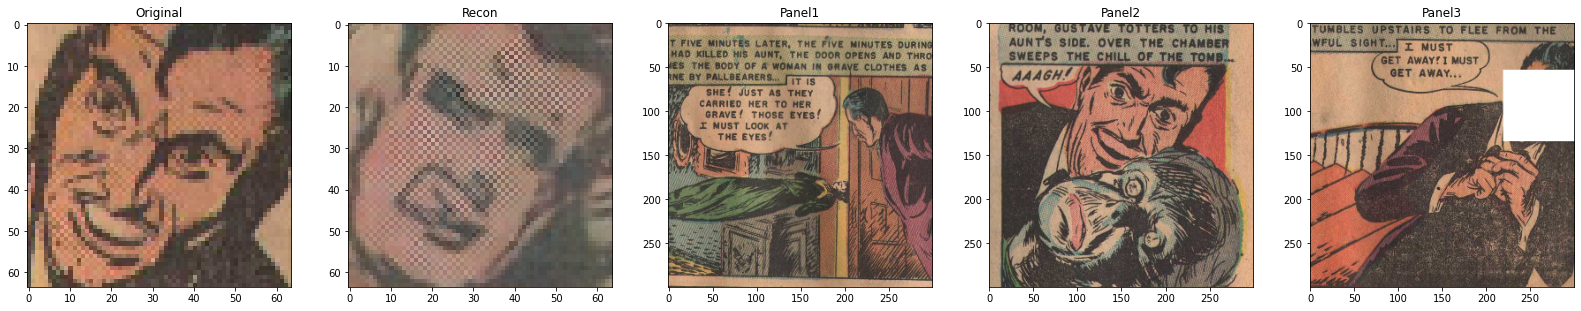

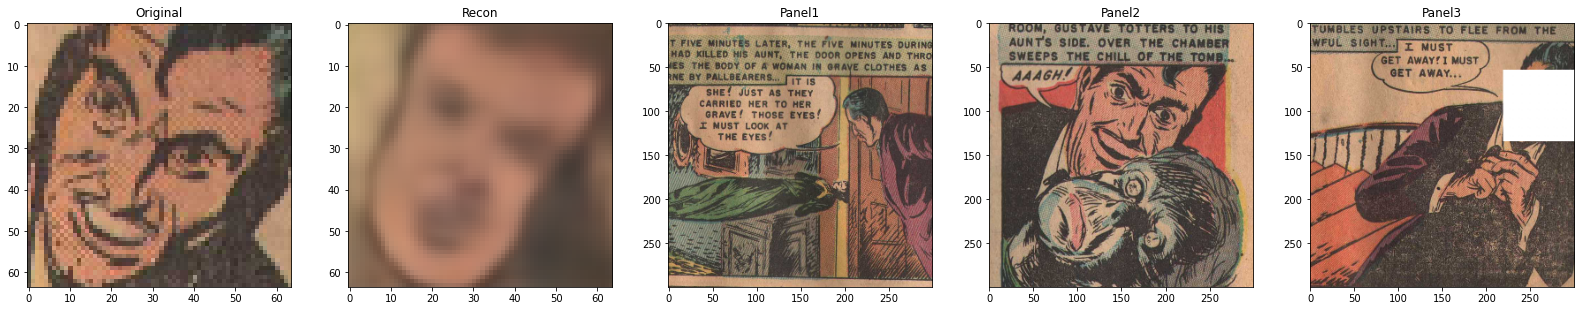

[INFO] Example: 1


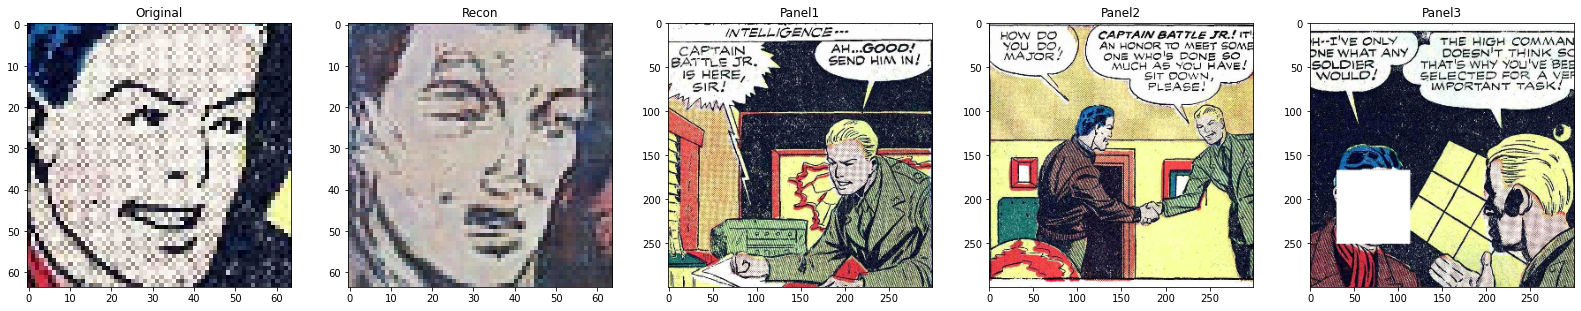

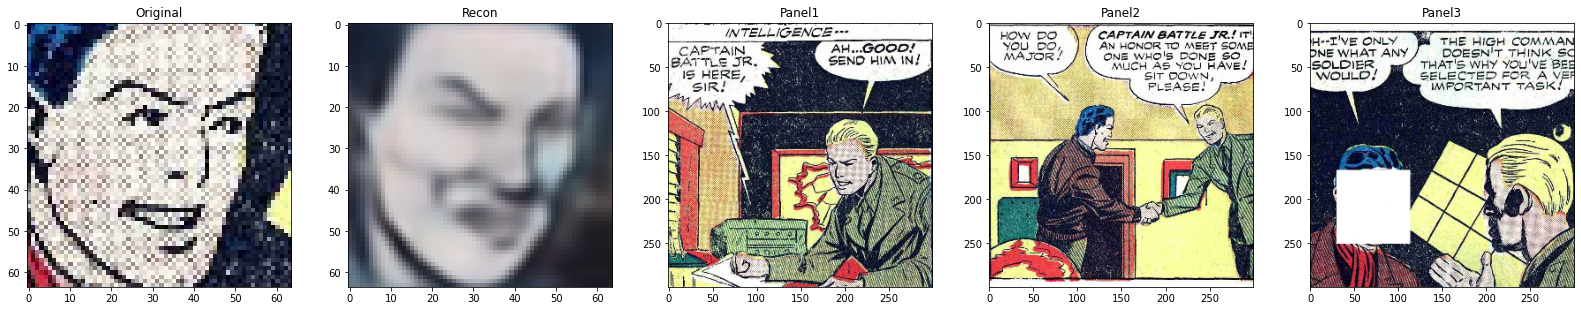

[INFO] Example: 2


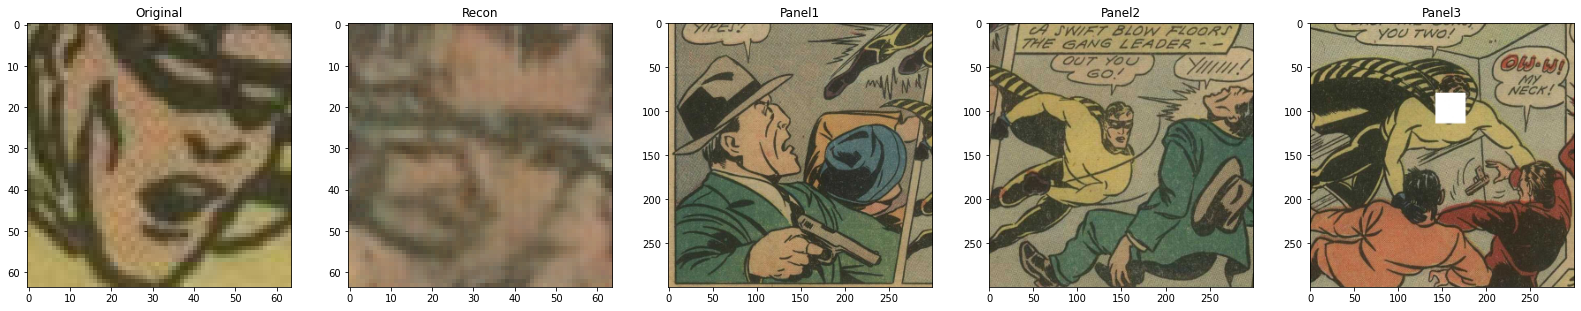

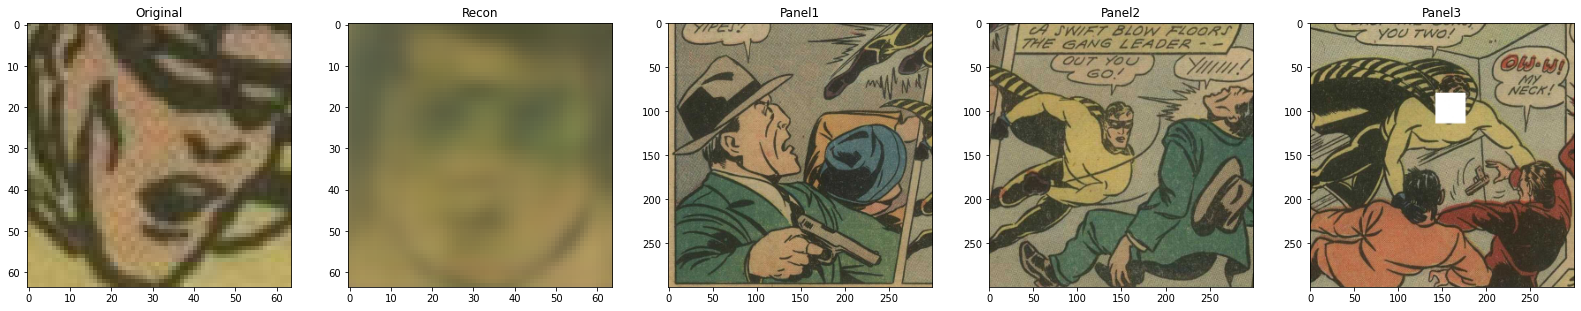

In [13]:


stds = torch.Tensor([0.229, 0.224, 0.225])
means = torch.Tensor([0.485, 0.456, 0.406])

ctr, limit = 0, 3

for i in range(limit):
    x, y, z = next(dl_iter)
    
    with torch.no_grad():
        _, _, _, y_recon, _ = net_ssuper_dcgan(x.cuda())  
        x_plain = (x + 1) / 2
        x_plain = TF.normalize(x_plain, mean=means, std=stds)
        
        _, _, _, py_recon, _ = net_ssupervae(x_plain.cuda()) 
        py_recon = py_recon * stds.view(1, 3, 1, 1).cuda() + means.view(1, 3, 1, 1).cuda()
        py_recon *= 2
        py_recon -= 1
        
        #py_recon -= 0.1
    print("[INFO] Example:", i)
    plot_panels_and_faces(x, y, y_recon.cpu())
    plot_panels_and_faces(x, y, py_recon.cpu())